# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [96]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [97]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [98]:
row_count = len(df)
row_count

294478

**c.** The number of unique users in the dataset.

In [99]:
uniq_count = df.user_id.nunique()
uniq_count

290584

**d.** The proportion of users converted.

In [100]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [101]:
len((df.query('group == "treatment"')).query('landing_page != "new_page"'))

1965

**f.** Do any of the rows have missing values?

In [102]:
df.isnull().sum().sum()

0

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



In [103]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(np.where((df.group == 'treatment') & (df.landing_page != 'new_page'))[0])

df2 = df2.drop(np.where((df.group != 'treatment') & (df.landing_page == 'new_page'))[0])

In [104]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [105]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [106]:
df2[df2['user_id'].duplicated()].index[0]

2893

**c.** Display the rows for the duplicate **user_id**? 

In [107]:
df2[df2.duplicated(subset=['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [108]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(df2[df2['user_id'].duplicated()].index[0], inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(subset=['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


### ToDo 1.4  
**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>


In [109]:
p_pop = df2.converted.mean()
p_pop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [110]:
ctrl_df = df2.query('group == "control"')
p_pop_ctrl = ctrl_df.converted.mean()
p_pop_ctrl

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [111]:
treat_df = df2.query('group == "treatment"')
p_pop_treat = treat_df.converted.mean()
p_pop_treat

0.11880806551510564

In [112]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_pop_treat - p_pop_ctrl
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [113]:
p_pop_new = (df2.landing_page == 'new_page').mean()
p_pop_new

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>The results of the probability calculations shows that there's relatively equal chance of an individual recieving either kind of page, but the old page appears to have a slightly higher conversion rate than the new page. This result is not conclusive when viewed under practical significance as the margin is little

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>H0 = Pnew - Pold <= 0

>H1 = Pnew - Pold > 0

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [114]:
p_new = round(df2.converted.mean(), 4)
p_new

0.1196

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [115]:
p_old = round(df2.converted.mean(), 4)
p_old

0.1196

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [116]:
n_new = len(treat_df)
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [117]:
n_old = len(ctrl_df)
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [118]:
# Simulate a Sample for the treatment Group
n_new_ones = treat_df.converted.mean() * n_new
array_new = np.array(treat_df.converted)
p_new_array = np.where(array_new == 1, (p_new)/n_new_ones, array_new)
p_new_array = np.where(p_new_array == 0, (1-p_new)/(n_new-n_new_ones), p_new_array)
new_page_converted = np.random.choice(array_new, n_new, replace=True, p=p_new_array)
new_page_converted.mean()

0.12032207005711926

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [119]:
# Simulate a Sample for the control Group
n_old_ones = ctrl_df.converted.mean() * n_old
array_old = np.array(ctrl_df.converted)
p_old_array = np.where(array_old == 1, (p_old)/n_old_ones, array_old)
p_old_array = np.where(p_old_array == 0, (1-p_old)/(n_old-n_old_ones), p_old_array)
old_page_converted = np.random.choice(array_old, n_old, replace=True, p=p_old_array)
old_page_converted.mean()

0.11936753995897408

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [120]:
p_diff = (new_page_converted.mean() - old_page_converted.mean())
p_diff

0.00095453009814518153


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [121]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  

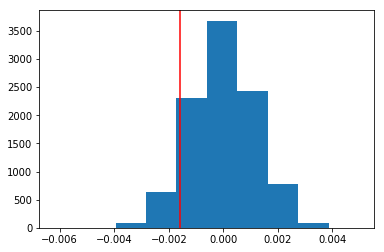

In [122]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [123]:
(np.array(p_diffs) > obs_diff).mean()

0.91020000000000001

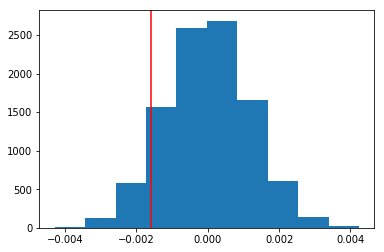

In [124]:
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(x=obs_diff, color='red');

In [125]:
(null_vals > obs_diff).mean()

0.90810000000000002

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>The value computed in **j** above is called a P-value. Given the type 1 error rate 0.05 and the observed p-value, we have statistical evidence to accept the null hypothesis that the convertion rate of the old_page is equal to the convertion rate of the new_page. This is because the value above represents the probability that the simulated convertion rate differences is greater than the observed convertion rate difference which was a low-negative value, and hence suggests that the difference tends to zero.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [126]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = n_old_ones

# number of conversions with the new_page
convert_new = n_new_ones

# number of individuals who were shown the old_page
n_old = n_old

# number of individuals who received new_page
n_new = n_new

#set arrays
count_array = np.array([convert_new, convert_old])
nobs_array = np.array([n_new, n_old])

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.


In [136]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments

z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative = 'larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>The z-score above is less than the value of 1.96, this doesn,t fall with the region to rejection region, hence we accept the null hypothesis. The p-value observed above also provides statistical evidence to accept the null hypothesis as it is above the type 1 error rate acceptable. They also agree with the findings in parts **j.** and **k.**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>Logistic Regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [128]:
df2['intercept'] = 1
df2[['control', 'treatment']] = pd.get_dummies(df['group'])
df2.rename(columns={'treatment':'ab_page'}, inplace=True)
df2.drop('control', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [129]:
lgm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = lgm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [130]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-14 12:16 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


>The p-value for ab_page is **0.1899**, the null hypothesis of the regression model is that the predictor variable does not have a statistically significant relationship with the response variable y. The p-value here when compared with the type 1 error rate shows evidence to accept the null hypothesis. The two hypothesis are two sided.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>Considering other factors to add to the regression model helps increase data available to conclude on whether the null hypothesis should be accepted or rejected, as it allows a broad scope of data to come to that conclusion. The disadvantage is  multicollinearity. Multicollinearity occurs when two or more parameters are collinear with each other.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

In [131]:
# Read the countries.csv
country = pd.read_csv('countries.csv')
country.head()
test = country.query('user_id == 851104')
test

,user_id,country
172334,851104,US


In [132]:
# Join with the df2 dataframe
df_merged = df2.merge(country, on='user_id')
df_merged.tail()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,US
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,US
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,US
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,US
290583,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1,UK


In [133]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [134]:
lgm2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
lgm2.fit().summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-14 12:16 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

> The p-values associated with the countries show statistical evidence that the countries had no impact on conversion when benchmarked with the type 1 error rate of 0.05

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [135]:
#create additional columns
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_US'] = df_merged['ab_page'] * df_merged['US']

# Fit your model, and summarize the results
lgm3 = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','UK','US','ab_UK', 'ab_US']])
lgm3.fit().summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-14 12:19 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_UK          0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
ab_US          0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

>The p-values associated with the page and countries show statistical evidence that the countries and page had no impact on conversion when benchmarked with the type 1 error rate of 0.05. They are all above the error threshhold, hence statistically, we fail to reject the null hypothesis that the convertion rate for the new page is equal to that of the old page. 
Practically, we can reject the null hypothesis for now, and advice the company to possibly run the tests a little longer before making final decisions.

.